<a href="https://colab.research.google.com/github/negarkamali/OOS/blob/main/Intent_classification_conforml_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import requests
import json
import re  # Import the regular expression module
import pandas as pd

url = "https://raw.githubusercontent.com/clinc/oos-eval/master/data/data_oos_plus.json"
response = requests.get(url)

if response.status_code == 200:
    # Save the file content to a file in the current working directory
    with open("data_oos_plus.json", "w") as file:
        file.write(response.text)
    print("File downloaded successfully!")
else:
    print("Failed to download the file. Status code:", response.status_code)




File downloaded successfully!


In [2]:
import json
import re
import requests

url = "https://raw.githubusercontent.com/clinc/oos-eval/master/data/data_oos_plus.json"
response = requests.get(url)

if response.status_code == 200:
    # Convert the file content to JSON
    data = json.loads(response.text)

    # Define a function to clean text
    def clean_text(text):
        text = text.lower()  # Convert to lowercase
        text = re.sub(r'[^a-z0-9\s]', '', text)  # Remove non-alphanumeric characters
        tokens = text.split()  # Simple tokenization (splitting by spaces)
        return ' '.join(tokens)

    # Clean the data
    cleaned_data = {}
    for key, value in data.items():
        cleaned_data[key] = [(clean_text(item[0]), item[1]) for item in value]

    # Save the cleaned data to a JSON file
    with open('cleaned_data.json', 'w') as f:
        json.dump(cleaned_data, f, indent=4)

    print("Data cleaned and saved to 'cleaned_data.json'")
else:
    print("Failed to download the file. Status code:", response.status_code)


Data cleaned and saved to 'cleaned_data.json'


In [4]:
import json
import nltk
from nltk.tokenize import word_tokenize

# Ensure that you have the punkt tokenizer models downloaded
nltk.download('punkt')

import json
from nltk.tokenize import word_tokenize

def tokenize_sentence(sentence):
    return word_tokenize(sentence)

def tokenize_data(input_path, output_path=None):
    # Load the data
    with open(input_path, 'r') as f:
        data = json.load(f)

    # Tokenize the data
    tokenized_data = {}
    for key, values in data.items():
        tokenized_data[key] = [[tokenize_sentence(sentence), label] for sentence, label in values]

    # Save the tokenized data (optional)
    if output_path:
        with open(output_path, 'w') as f:
            json.dump(tokenized_data, f, indent=4)

    return tokenized_data

# Input and output file paths
input_path = 'cleaned_data.json'
output_path = 'tokenized_data.json'

# Tokenize and save the data
tokenized_data = tokenize_data(input_path, output_path)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
import json
import tensorflow_hub as hub
import numpy as np
import os

# Load Universal Sentence Encoder
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

def embed_sentences(sentences):
    return embed(sentences)

def load_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

def preprocess_and_save(data, output_file):
    for key in data:
        sentences = [item[0] for item in data[key]]
        embeddings = embed_sentences(sentences)
        for i, item in enumerate(data[key]):
            item[0] = embeddings[i].numpy().tolist()  # Convert embedding to list
    with open(output_file, 'w') as f:
        json.dump(data, f)

if __name__ == "__main__":
    input_file = 'cleaned_data.json'
    output_file = 'data_oos_plus_embedded.json'
    data = load_data(input_file)
    preprocess_and_save(data, output_file)

In [6]:
import json
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

def load_and_preprocess_data():
    # Define file path
    file_path = 'data_oos_plus_embedded.json'

    # Load data from JSON file
    with open(file_path, 'r') as f:
        data = json.load(f)

    # Separate features (X) and labels (y) for in-scope and out-of-scope data
    X_train, y_train = zip(*[(embedding, label) for embedding, label in data["train"]])
    X_val, y_val = zip(*[(embedding, label) for embedding, label in data["val"]])
    X_test, y_test = zip(*[(embedding, label) for embedding, label in data["test"]])

    X_train_oos, y_train_oos = zip(*[(embedding, 'oos') for embedding, label in data["oos_train"]])
    X_val_oos, y_val_oos = zip(*[(embedding, 'oos') for embedding, label in data["oos_val"]])
    X_test_oos, y_test_oos = zip(*[(embedding, 'oos') for embedding, label in data["oos_test"]])

    # Convert lists to numpy arrays
    X_train = np.array(X_train)
    X_val = np.array(X_val)
    X_test = np.array(X_test)

    X_train_oos = np.array(X_train_oos)
    X_val_oos = np.array(X_val_oos)
    X_test_oos = np.array(X_test_oos)

    print("X_train shape:", (X_train).shape)
    print("X_train_oos shape:", (X_train_oos).shape)
    # Combine in-scope and out-of-scope data
    X_train_combined = np.vstack([X_train, X_train_oos])
    X_val_combined = np.vstack([X_val, X_val_oos])
    X_test_combined = np.vstack([X_test, X_test_oos])

    print("X_train_combined shape:", (X_train_combined).shape)
    y_train_combined = y_train + y_train_oos
    y_val_combined = y_val + y_val_oos
    y_test_combined = y_test + y_test_oos

    # Convert labels to integers using LabelEncoder, fitting on the combined label set
    label_encoder = LabelEncoder()
    y_train_combined = label_encoder.fit_transform(y_train_combined)
    y_val_combined = label_encoder.transform(y_val_combined)
    y_test_combined = label_encoder.transform(y_test_combined)

    # Convert integer labels to one-hot encoding
    y_train_combined = to_categorical(y_train_combined)
    y_val_combined = to_categorical(y_val_combined)
    y_test_combined = to_categorical(y_test_combined)


    return (X_train_combined, y_train_combined), (X_val_combined, y_val_combined), (X_test_combined, y_test_combined), label_encoder

if __name__ == "__main__":
    (X_train, y_train), (X_val, y_val), (X_test, y_test), label_encoder = load_and_preprocess_data()


X_train shape: (15000, 512)
X_train_oos shape: (250, 512)
X_train_combined shape: (15250, 512)


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import recall_score
import numpy as np
import os

everything from here on is including the out-of-distribution data (combined)

In [8]:
from sklearn.model_selection import train_test_split
# Load preprocessed data
(X_train, y_train), (X_val, y_val), (X_test, y_test), label_encoder = load_and_preprocess_data()
# Convert y_test from one-hot encoding to label encoding for stratification
y_test_labels = np.argmax(y_test, axis=1)

# Split test set into calibration and final test set (50-50 split)
X_cal, X_test_final, y_cal, y_test_final = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42, stratify=y_test
)


X_train shape: (15000, 512)
X_train_oos shape: (250, 512)
X_train_combined shape: (15250, 512)


In [30]:
# Define and compile the model
model_MLP = Sequential([
    Dense(200, input_shape=(X_train.shape[1],), activation='tanh'),
    Dropout(0.5),
    Dense(200, activation='tanh'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
])

In [31]:
model_MLP.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
X_val.shape

(3100, 512)

In [14]:
X_train.shape

(15250, 512)

In [15]:
X_cal.shape

(2750, 512)

In [16]:
X_test_final.shape

(2750, 512)

In [32]:
# Train the model
model_MLP.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=16)

Epoch 1/50
954/954 [==============================] - 9s 7ms/step - loss: 2.2294 - accuracy: 0.5577 - val_loss: 0.6113 - val_accuracy: 0.8768
Epoch 2/50
954/954 [==============================] - 9s 9ms/step - loss: 0.6087 - accuracy: 0.8453 - val_loss: 0.3721 - val_accuracy: 0.9171
Epoch 3/50
954/954 [==============================] - 7s 8ms/step - loss: 0.4369 - accuracy: 0.8797 - val_loss: 0.3236 - val_accuracy: 0.9252
Epoch 4/50
954/954 [==============================] - 8s 9ms/step - loss: 0.3619 - accuracy: 0.8998 - val_loss: 0.2993 - val_accuracy: 0.9284
Epoch 5/50
954/954 [==============================] - 6s 7ms/step - loss: 0.3132 - accuracy: 0.9112 - val_loss: 0.2918 - val_accuracy: 0.9306
Epoch 6/50
954/954 [==============================] - 4s 5ms/step - loss: 0.3017 - accuracy: 0.9097 - val_loss: 0.2866 - val_accuracy: 0.9335
Epoch 7/50
954/954 [==============================] - 4s 4ms/step - loss: 0.2690 - accuracy: 0.9209 - val_loss: 0.2810 - val_accuracy: 0.9361
Epoch 

In [33]:
# Evaluate the model on the test data
loss, accuracy = model_MLP.evaluate(X_test_final, y_test_final)
print("Test Accuracy:", accuracy)

86/86 [==============================] - 0s 2ms/step - loss: 1.0282 - accuracy: 0.8505
Test Accuracy: 0.8505454659461975


In [34]:

# Identify the 'oos' class index
oos_class_index = label_encoder.transform(['oos'])[0]

# Predictions for out-of-scope data
oos_predictions = model_MLP.predict(X_test_final[y_test_final[:, oos_class_index] == 1])
oos_predictions_labels = np.argmax(oos_predictions, axis=-1)

# True labels for out-of-scope data
y_test_oos_true_labels = np.full(oos_predictions_labels.shape, oos_class_index)

# Calculate recall for out-of-scope data
oos_recall = recall_score(y_test_oos_true_labels, oos_predictions_labels, average='micro')
print("Out-of-scope Recall:", oos_recall)


16/16 [==============================] - 0s 2ms/step
Out-of-scope Recall: 0.47


conformal prediction

In [51]:
 #Convert the target values from one-hot encoding to label encoding

y_train_labels = np.argmax(y_train, axis=1)
y_cal_labels = np.argmax(y_cal, axis=1)

from sklearn.neural_network import MLPClassifier
# # Initialize and train the MLP classifier
clf = MLPClassifier(random_state=42).fit(X_train, y_train_labels)

y_pred_proba = clf.predict_proba(X_test_final)



In [ ]:
!pip install mapie

In [52]:
probabilities = clf.predict_proba(X_cal)
assert np.allclose(probabilities.sum(axis=1), 1), "Probabilities do not sum up to 1"


In [57]:

# Initialize MAPIE
from mapie.classification import MapieClassifier
mapie_score = MapieClassifier(estimator=clf, cv="prefit", method="raps")
mapie_score.fit(X_cal, y_cal_labels)

MapieClassifier(cv='prefit', estimator=MLPClassifier(random_state=42),
                method='raps')

In [58]:
alpha = [0.05]
y_pred_score, y_ps_score = mapie_score.predict(X_test_final, alpha=alpha)

In [60]:

results = pd.DataFrame(list(map(np.ravel, y_ps_score)))
results['prediction'] = y_pred_score

y_test_labels = np.argmax(y_test_final, axis=1)
results['label'] = y_test_labels

In [61]:
results

,0,1,2,3,4,5,6,7,8,9,...,143,144,145,146,147,148,149,150,prediction,label
0,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,99,99
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,141,141
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,49,49
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,112,112
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,133,133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2745,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,116,80
2746,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,9,9
2747,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,129,80
2748,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,102,102


In [62]:
def set_pandas_display_options() -> None:
    """Set pandas display options."""
    # Ref: https://stackoverflow.com/a/52432757/
    display = pd.options.display

    display.max_columns = 1000
    display.max_rows = 1000
    display.max_colwidth = 199
    display.width = 1000
    # display.precision = 2  # set as needed
    # display.float_format = lambda x: '{:,.2f}'.format(x)  # set as needed
set_pandas_display_options()

In [63]:
filtered_results = results.loc[results['prediction'] != results['label']]
print("Shape of filtered_results:", filtered_results.shape)

Shape of filtered_results: (340, 153)


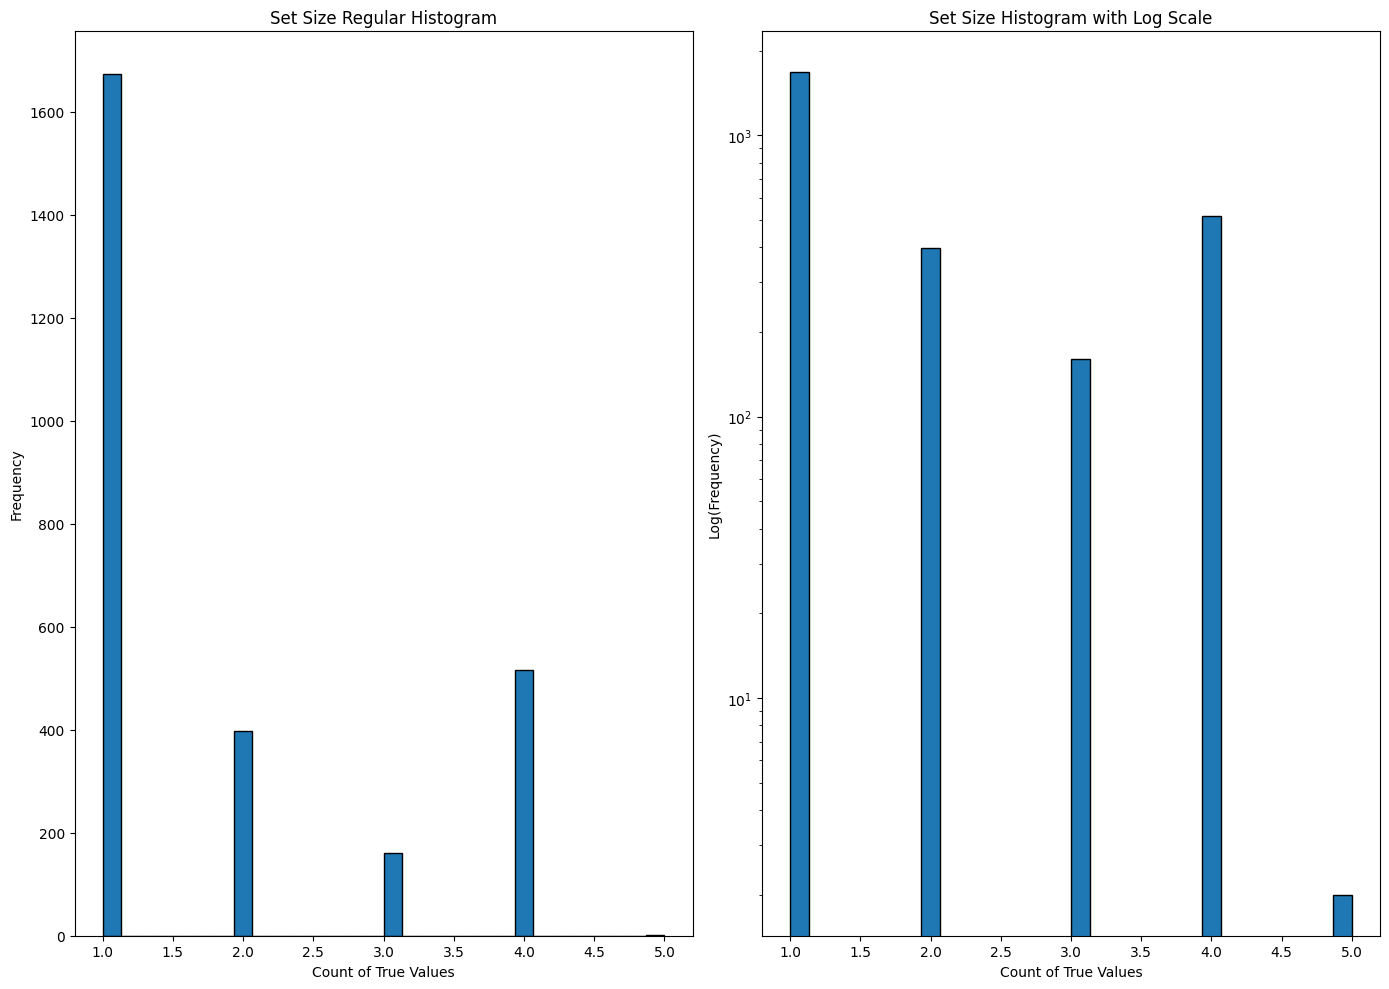

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate the true count
results['true_count'] = results.iloc[:, :-2].apply(lambda row: sum(row == True), axis=1)

# Plotting with different strategies
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 10))

# Regular Histogram
axes[0].hist(results['true_count'], bins=30, edgecolor='black')
axes[0].set_title('Set Size Regular Histogram')
axes[0].set_xlabel('Count of True Values')
axes[0].set_ylabel('Frequency')

# Log Scale
axes[1].hist(results['true_count'], bins=30, edgecolor='black', log=True)
axes[1].set_title('Set Size Histogram with Log Scale')
axes[1].set_xlabel('Count of True Values')
axes[1].set_ylabel('Log(Frequency)')


plt.tight_layout()
plt.show()


In [ ]:
# y_true is  one-hot encoded ground truth and y_pred is the softmax output of model - ONLY for in-distribution


In [ ]:
cross_entropy_losses = -np.sum(y_true * np.log(y_pred + 1e-10), axis=1)  # Added a small value to avoid log(0)

# Plot the distribution
plt.hist(cross_entropy_losses, bins=50, edgecolor='black')
plt.title('Distribution of Cross-Entropy Losses for Intent Classification')
plt.xlabel('Cross-Entropy Loss')
plt.ylabel('Frequency')
plt.show()

# Determine the threshold for categorizing difficulty
median_loss = np.median(cross_entropy_losses)
print(f"Median Cross-Entropy Loss: {median_loss}")

# Categorize samples based on the threshold
easy_samples = np.where(cross_entropy_losses <= median_loss)
hard_samples = np.where(cross_entropy_losses > median_loss)
